# Simple RNN — Prédiction autorégressiive et Vanishing Gradient

## Objectif
Ce notebook construit un **SimpleRNN** pour prédire `Total_reservations`,
tout en illustrant le **problème du vanishing gradient**.

## Formule du SimpleRNN
$$h_t = \tanh(W_{ih}\, x_t + b_{ih} + W_{hh}\, h_{t-1} + b_{hh})$$

## Pourquoi le vanishing gradient ?
Lors de la BPTT (BackPropagation Through Time), le gradient doit traverser
le produit de matrices récurrentes :
$$\frac{\partial \mathcal{L}}{\partial h_1} = \frac{\partial \mathcal{L}}{\partial h_T}
\prod_{t=2}^{T} W_{hh}^\top \mathrm{diag}(\tanh'(h_{t-1}))$$
- $\tanh'(x) \leq 1$ → chaque facteur atténue le gradient
- Si $\|W_{hh}\| < 1$ → le gradient **disparaît exponentiellement** en $T$
- Le réseau oublie les dépendances éloignées → LSTM/GRU nécessaires

## Paramètres comparables inter-modèles
| Paramètre | Valeur | Rôle |
|-----------|--------|------|
| `WINDOW` | 5 | Jours de contexte (1 semaine ouvrée) |
| `N_TEST` | 5 | Jours à prédire (dernière semaine) |
| `TARGET_COL` | `Total_reservations` | Variable cible |
| `EPOCHS` | 200 | Epochs max d'entraînement |
| `HIDDEN_SIZE` | 64 | Dimension de l'état caché |

## 1 — Configuration globale

**Modifiez uniquement ce bloc** pour changer les hyperparamètres.

In [67]:
# ─────────────────────────────────────────────────────────────────
# PARAMÈTRES GLOBAUX — modifier ici pour ajuster l'expérience
# ─────────────────────────────────────────────────────────────────
DATA_PATH   = '../data/df_venues_final.csv'
TARGET_COL  = 'GLOBAL'
MODEL_NAME  = 'RNN'

WINDOW      = 5      # jours de contexte (fenêtre glissante)
N_TEST      = 5      # jours de test = dernière semaine
N_VAL       = 20     # jours de validation (~4 semaines)

# Entraînement
EPOCHS      = 200
LR          = 1e-3
BATCH_SIZE  = 16
WEIGHT_DECAY = 1e-5
PATIENCE    = 20

# Architecture RNN
HIDDEN_SIZE = 64
NUM_LAYERS  = 1     # SimpleRNN : 1 couche (déjà complexe pour vanishing gradient)
DROPOUT     = 0.0   # pas de dropout sur 1 couche

# Expérience vanishing gradient : tailles de fenêtre à tester
WINDOWS_EXP     = [2, 5, 10, 20]
EPOCHS_EXP      = 50

FEATURES = [
    'GLOBAL',
    'Total_reservations', 'Temp', 'pluie', 'autre',
    'Greve_nationale', 'prof_nationale',
    'jour_ferie.', 'pont.conge.', 'holiday',
    'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_jeudi', 'jour_vendredi',
]
TARGET_IDX = 0

DAY_LABELS = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
IMG_PATH   = f'../img/{MODEL_NAME.lower()}_results.png'

## 2 — Imports

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch : {torch.__version__} | Device : {DEVICE}')

PyTorch : 2.10.0 | Device : cpu


## 3 — Chargement et tri chronologique

In [69]:
df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
for col in day_order:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

print(f'Shape : {df.shape}')
_last = df.iloc[-N_TEST:]
TEST_LABEL = f"S{int(_last.iloc[0]['Semaine'])}/{int(_last.iloc[0]['Annee'])}"
print(f'Période : {df["Annee"].min()}/S{df["Semaine"].min()} → {df["Annee"].max()}/S{df["Semaine"].max()}')
print(f'\n--- Dernière semaine de test ({TEST_LABEL}) ---')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].tail(N_TEST).to_string())

Shape : (250, 18)
Période : 2022/S1 → 2023/S51

--- Dernière semaine de test (S39/2023) ---
     Annee  Semaine  day_num  GLOBAL
245   2023       39        0     624
246   2023       39        1     713
247   2023       39        2     623
248   2023       39        3     659
249   2023       39        4     408


## 4 — Prétraitement, split et séquences

### Split temporel hold-out
```
|←────────── Train (225 j) ──────────→|←── Val (20 j) ──→|← Test (5 j) →|
   S1/2022 → S12/2023                    S13 → S16/2023     S39/2023
```
- **Train** : apprentissage des poids du modèle
- **Val** : early stopping — les meilleurs poids sont ceux minimisant la val loss
- **Test** : évaluation finale (jamais vu pendant l'entraînement)

> ⚠️ Règle absolue : le scaler est ajusté **uniquement sur le train**
> pour éviter toute fuite d'information (data leakage) du futur vers le passé.

### Normalisation
`MinMaxScaler` ajusté sur le train, appliqué au val et au test.

### Séquences glissantes
Chaque sample `(X, y)` : fenêtre de `WINDOW` jours → cible du jour suivant.

In [70]:
scaler   = MinMaxScaler()

# ── Split temporel strict : Train | Val | Test ───────────────────────────
n_total    = len(df)
test_start = n_total - N_TEST          # premier jour du test   (ex: 245)
val_start  = test_start - N_VAL        # premier jour de la val (ex: 225)

# Scaler ajusté UNIQUEMENT sur le train (pas de data leakage)
scaler.fit(df[FEATURES].astype(float).iloc[:val_start])
X_scaled = scaler.transform(df[FEATURES].astype(float))

X_train_raw = X_scaled[:val_start]                        # 0 → val_start-1
X_val_raw   = X_scaled[val_start - WINDOW : test_start]   # contexte inclu
X_test_raw  = X_scaled[test_start:]                       # derniers N_TEST jours

def make_sequences(X, window):
    """Transforme un tableau (N, F) en séquences glissantes pour apprentissage supervisé."""
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i])
        ys.append(X[i, TARGET_IDX])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32).reshape(-1, 1)

X_seq,     y_seq     = make_sequences(X_train_raw, WINDOW)   # séquences train
X_val_seq, y_val_seq = make_sequences(X_val_raw,   WINDOW)   # séquences val

# Labels de période
_val      = df.iloc[val_start  : test_start]
VAL_LABEL = f"S{int(_val.iloc[0]['Semaine'])}–S{int(_val.iloc[-1]['Semaine'])}/{int(_val.iloc[-1]['Annee'])}"

print('=== Split temporel ===')
print(f'  Train : {val_start:3d} jours  (0 – {val_start-1})')
print(f'  Val   : {N_VAL:3d} jours  ({val_start} – {test_start-1})  [{VAL_LABEL}]')
print(f'  Test  : {N_TEST:3d} jours  ({test_start} – {n_total-1})  [{TEST_LABEL}]')
print(f'\nSéquences → Train : {X_seq.shape}  |  Val : {X_val_seq.shape}')
seed_start = test_start - WINDOW
print(f'\nFenêtre seed test (indices {seed_start}–{test_start-1}) :')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].iloc[seed_start:test_start].to_string())

X_tr  = torch.tensor(X_seq).to(DEVICE)
y_tr  = torch.tensor(y_seq).to(DEVICE)
X_val = torch.tensor(X_val_seq).to(DEVICE)
y_val = torch.tensor(y_val_seq).to(DEVICE)
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)

=== Split temporel ===
  Train : 225 jours  (0 – 224)
  Val   :  20 jours  (225 – 244)  [S35–S38/2023]
  Test  :   5 jours  (245 – 249)  [S39/2023]

Séquences → Train : (220, 5, 15)  |  Val : (20, 5, 15)

Fenêtre seed test (indices 240–244) :
     Annee  Semaine  day_num  GLOBAL
240   2023       38        0     676
241   2023       38        1     764
242   2023       38        2     714
243   2023       38        3     677
244   2023       38        4     558


## 5 — Architecture SimpleRNN

```
Input  : (batch, WINDOW=5, n_features=15)
   ↓
RNN(hidden=64, layers=1, nonlinearity='tanh')
   ↓  h_T  (batch, 64)
Linear(64 → 1)
   ↓
Total_reservations normalisé [0, 1]
```

**Différence vs LSTM/GRU :** aucune porte de mémoire → le gradient disparaît sur de longues séquences.
On capture les gradients de `W_hh` (poids récurrents) pour visualiser ce phénomène.

In [71]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


model = SimpleRNNModel(input_size=len(FEATURES)).to(DEVICE)
print(model)
print(f'\nNombre de paramètres : {sum(p.numel() for p in model.parameters()):,}')
print(f'(vs LSTM ≈ 54k, GRU ≈ 40k)')

SimpleRNNModel(
  (rnn): RNN(15, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Nombre de paramètres : 5,249
(vs LSTM ≈ 54k, GRU ≈ 40k)


## 6 — Entraînement + capture des gradients

On enregistre la **norme L2 du gradient** de `W_hh` (poids récurrents) à chaque epoch.
C'est cette matrice qui est répétitivement multipliée lors de la BPTT → source du vanishing gradient.

In [72]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=PATIENCE, factor=0.5
)

loss_history  = {'train': [], 'val': []}
grad_history  = {'rnn.weight_ih_l0': [], 'rnn.weight_hh_l0': [], 'fc.weight': []}
best_val_loss = float('inf')
best_state    = None
no_improve    = 0

for epoch in range(1, EPOCHS + 1):
    # ── Phase train ───────────────────────────────────────────────────────
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    train_loss = epoch_loss / len(X_seq)

    # Capture des normes de gradient (vanishing gradient)
    for name, param in model.named_parameters():
        if name in grad_history and param.grad is not None:
            grad_history[name].append(param.grad.norm().item())

    # ── Phase validation ──────────────────────────────────────────────────
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val).item()

    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)

    # ── Early stopping sur la val loss ────────────────────────────────────
    scheduler.step(val_loss)
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state    = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve    = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE * 2:
            print(f'Early stopping epoch {epoch}  (best val MSE = {best_val_loss:.5f})')
            break

    if epoch % 50 == 0:
        whh = grad_history['rnn.weight_hh_l0'][-1] if grad_history['rnn.weight_hh_l0'] else 0
        lr_cur = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:3d}/{EPOCHS} | Train : {train_loss:.5f} | Val : {val_loss:.5f} | ‖∇W_hh‖ : {whh:.6f}')

if best_state:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    print(f'\nMeilleurs poids restaurés  (val MSE = {best_val_loss:.5f})')
print('Entraînement terminé.')

Early stopping epoch 44  (best val MSE = 0.00246)

Meilleurs poids restaurés  (val MSE = 0.00246)
Entraînement terminé.


## 7 — Prédiction autorégressiive (fenêtre glissante)

In [73]:
model.eval()

seed_window = X_scaled[-N_TEST - WINDOW : -N_TEST].copy()
preds_norm  = []
window      = seed_window.copy()

print('=== Prédiction autorégressiive ===')
print(f"{'Étape':<6} {'Jour':<10} {'ŷ norm':>8}   Fenêtre {TARGET_COL} [normalisé]")
print('-' * 70)

for step in range(N_TEST):
    x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred_n = model(x).item()
    preds_norm.append(pred_n)

    print(f'  {step}     {DAY_LABELS[step]:<10} {pred_n:>8.4f}   '
          f'{np.round(window[:, TARGET_IDX], 3)}')

    new_day             = X_test_raw[step].copy()
    new_day[TARGET_IDX] = pred_n
    window = np.vstack([window[1:], new_day.reshape(1, -1)])

dummy                = np.zeros((N_TEST, len(FEATURES)))
dummy[:, TARGET_IDX] = preds_norm
preds_real = scaler.inverse_transform(dummy)[:, TARGET_IDX]
real_real  = df[TARGET_COL].values[-N_TEST:]

print('\n=== Résultats ===')
print(f"{'Jour':<10} | {'Réel':>6} | {MODEL_NAME:>6} | {'Erreur':>7} | {'Erreur %':>8}")
print('-' * 48)
for i, d in enumerate(DAY_LABELS):
    err    = preds_real[i] - real_real[i]
    err_pc = 100 * abs(err) / real_real[i]
    print(f'{d:<10} | {real_real[i]:>6.0f} | {preds_real[i]:>6.0f} | {err:>+7.0f} | {err_pc:>7.1f}%')

=== Prédiction autorégressiive ===
Étape  Jour         ŷ norm   Fenêtre GLOBAL [normalisé]
----------------------------------------------------------------------
  0     Lundi        0.6675   [0.718 0.814 0.76  0.719 0.589]
  1     Mardi        0.7602   [0.814 0.76  0.719 0.589 0.668]
  2     Mercredi     0.7579   [0.76  0.719 0.589 0.668 0.76 ]
  3     Jeudi        0.6905   [0.719 0.589 0.668 0.76  0.758]
  4     Vendredi     0.5004   [0.589 0.668 0.76  0.758 0.69 ]

=== Résultats ===
Jour       |   Réel |    RNN |  Erreur | Erreur %
------------------------------------------------
Lundi      |    624 |    630 |      +6 |     0.9%
Mardi      |    713 |    715 |      +2 |     0.2%
Mercredi   |    623 |    712 |     +89 |    14.4%
Jeudi      |    659 |    651 |      -8 |     1.2%
Vendredi   |    408 |    477 |     +69 |    16.9%


## 8 — Métriques

In [74]:
# ── Métriques Val : prédiction directe 1-pas ─────────────────────────────
model.eval()
with torch.no_grad():
    val_preds_norm = model(X_val).cpu().numpy().flatten()

dummy_val                = np.zeros((N_VAL, len(FEATURES)))
dummy_val[:, TARGET_IDX] = val_preds_norm
val_preds_real = scaler.inverse_transform(dummy_val)[:, TARGET_IDX]
val_real       = df[TARGET_COL].values[val_start : test_start]

mae_val  = mean_absolute_error(val_real, val_preds_real)
mape_val = mean_absolute_percentage_error(val_real, val_preds_real) * 100
rmse_val = np.sqrt(np.mean((val_real - val_preds_real) ** 2))
r2_val   = r2_score(val_real, val_preds_real)

# ── Métriques Test : prédiction autorégressiive ───────────────────────────
mae  = mean_absolute_error(real_real, preds_real)
mape = mean_absolute_percentage_error(real_real, preds_real) * 100
rmse = np.sqrt(np.mean((real_real - preds_real) ** 2))
r2   = r2_score(real_real, preds_real)

# ── Affichage comparatif ──────────────────────────────────────────────────
W = 54
print(f'{"="*W}')
print(f'  {MODEL_NAME} — Métriques de généralisation')
print(f'{"="*W}')
print(f'  {"Métrique":<18} {"Val 1-step":>14} {"Test autorégressif":>18}')
print(f'  {"-"*W}')
print(f'  {"MAE  (venues)":<18} {mae_val:>14.1f} {mae:>18.1f}')
print(f'  {"MAPE (%)":<18} {mape_val:>14.2f} {mape:>18.2f}')
print(f'  {"RMSE (venues)":<18} {rmse_val:>14.1f} {rmse:>18.1f}')
print(f'  {"R²":<18} {r2_val:>14.4f} {r2:>18.4f}')
print(f'{"="*W}')
print(f'  Val  = {VAL_LABEL} (prédiction directe 1-pas)')
print(f'  Test = {TEST_LABEL} (autorégressif {N_TEST} jours)')

  RNN — Métriques de généralisation
  Métrique               Val 1-step Test autorégressif
  ------------------------------------------------------
  MAE  (venues)                33.8               34.8
  MAPE (%)                     6.03               6.73
  RMSE (venues)                45.4               50.7
  R²                         0.8514             0.7624
  Val  = S35–S38/2023 (prédiction directe 1-pas)
  Test = S39/2023 (autorégressif 5 jours)


## 9 — Visualisations standardisées

Identiques aux autres modèles + un graphique supplémentaire sur les gradients.

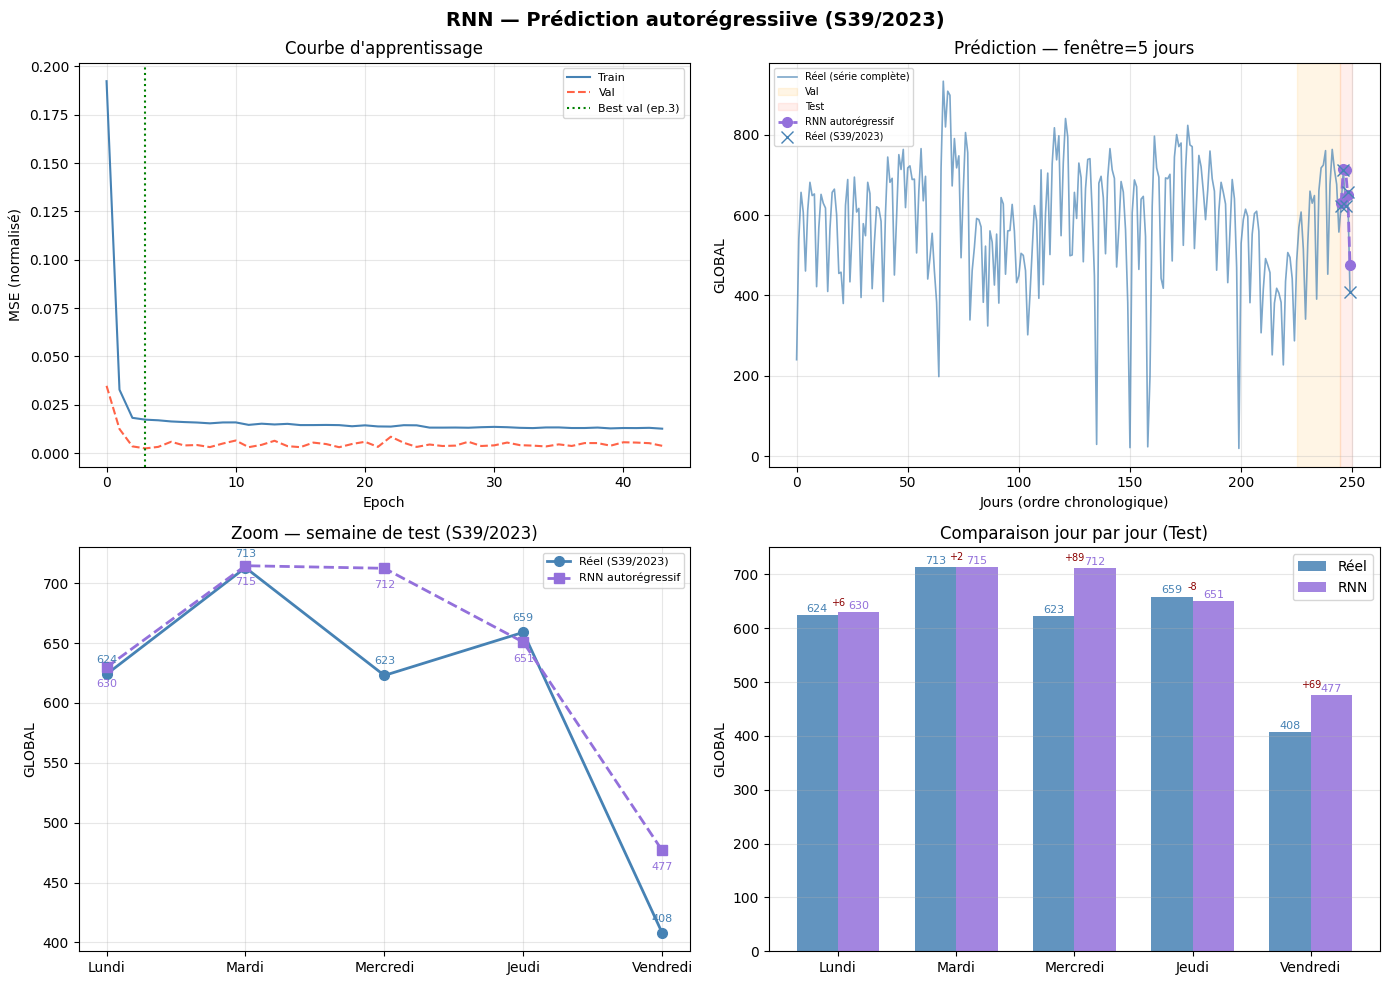

Figure sauvegardée → ../img/rnn_results.png


In [75]:
all_real     = df[TARGET_COL].values
test_indices = list(range(len(all_real) - N_TEST, len(all_real)))
val_indices  = list(range(val_start, test_start))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'{MODEL_NAME} — Prédiction autorégressiive ({TEST_LABEL})',
             fontsize=14, fontweight='bold')

# ── 1 : Courbes d'apprentissage (train + val) ─────────────────────────────
ax = axes[0, 0]
ax.plot(loss_history['train'], color='steelblue', lw=1.5, label='Train')
ax.plot(loss_history['val'],   color='tomato',    lw=1.5, ls='--', label='Val')
best_ep = int(np.argmin(loss_history['val']))
ax.axvline(x=best_ep, color='green', ls=':', lw=1.5, label=f'Best val (ep.{best_ep})')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE (normalisé)')
ax.set_title("Courbe d'apprentissage")
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# ── 2 : Série complète + périodes val/test ────────────────────────────────
ax = axes[0, 1]
ax.plot(range(len(all_real)), all_real,
        label='Réel (série complète)', color='steelblue', alpha=0.7, lw=1.2)
ax.axvspan(val_start, test_start - 0.5, alpha=0.10, color='orange', label='Val')
ax.axvspan(test_start - 0.5, len(all_real), alpha=0.10, color='tomato', label='Test')
ax.plot(test_indices, preds_real,
        label=f'{MODEL_NAME} autorégressif', color='mediumpurple',
        ls='--', marker='o', ms=7, lw=2)
ax.plot(test_indices, real_real,
        color='steelblue', marker='x', ms=9, ls='None', label=f'Réel ({TEST_LABEL})')
ax.set_xlabel('Jours (ordre chronologique)')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Prédiction — fenêtre={WINDOW} jours')
ax.legend(fontsize=7)
ax.grid(alpha=0.3)

# ── 3 : Zoom semaine de test ──────────────────────────────────────────────
ax = axes[1, 0]
ax.plot(DAY_LABELS, real_real,  'o-', color='steelblue',    ms=7, lw=2, label=f'Réel ({TEST_LABEL})')
ax.plot(DAY_LABELS, preds_real, 's--', color='mediumpurple', ms=7, lw=2, label=f'{MODEL_NAME} autorégressif')
for i, (r, p) in enumerate(zip(real_real, preds_real)):
    ax.annotate(f'{r:.0f}', (i, r), textcoords='offset points', xytext=(0, 8),
                ha='center', fontsize=8, color='steelblue')
    ax.annotate(f'{p:.0f}', (i, p), textcoords='offset points', xytext=(0, -14),
                ha='center', fontsize=8, color='mediumpurple')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Zoom — semaine de test ({TEST_LABEL})')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# ── 4 : Barres côte à côte ───────────────────────────────────────────────
ax    = axes[1, 1]
x     = np.arange(N_TEST)
width = 0.35
b_r   = ax.bar(x - width/2, real_real,  width, label='Réel',     color='steelblue',   alpha=0.85)
b_p   = ax.bar(x + width/2, preds_real, width, label=MODEL_NAME, color='mediumpurple', alpha=0.85)
for bar, val in zip(b_r, real_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='steelblue')
for bar, val in zip(b_p, preds_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='mediumpurple')
ax.set_xticks(x)
ax.set_xticklabels(DAY_LABELS)
ax.set_ylabel(TARGET_COL)
ax.set_title('Comparaison jour par jour (Test)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i in range(N_TEST):
    err = preds_real[i] - real_real[i]
    ax.text(i, max(real_real[i], preds_real[i]) + 12,
            f'{err:+.0f}', ha='center', fontsize=7, color='darkred')

plt.tight_layout()
plt.savefig(IMG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure sauvegardée → {IMG_PATH}')

## 10 — Analyse du Vanishing Gradient

### Visualisation des normes de gradients par couche
On compare :
- `W_ih` : poids entrée → caché (gradient de surface)
- `W_hh` : **poids récurrents** (source du vanishing)
- `W_fc` : poids de la couche de sortie (gradient fort, proche de la loss)

On s'attend à voir `W_hh` avec une norme bien plus faible que `W_fc`.

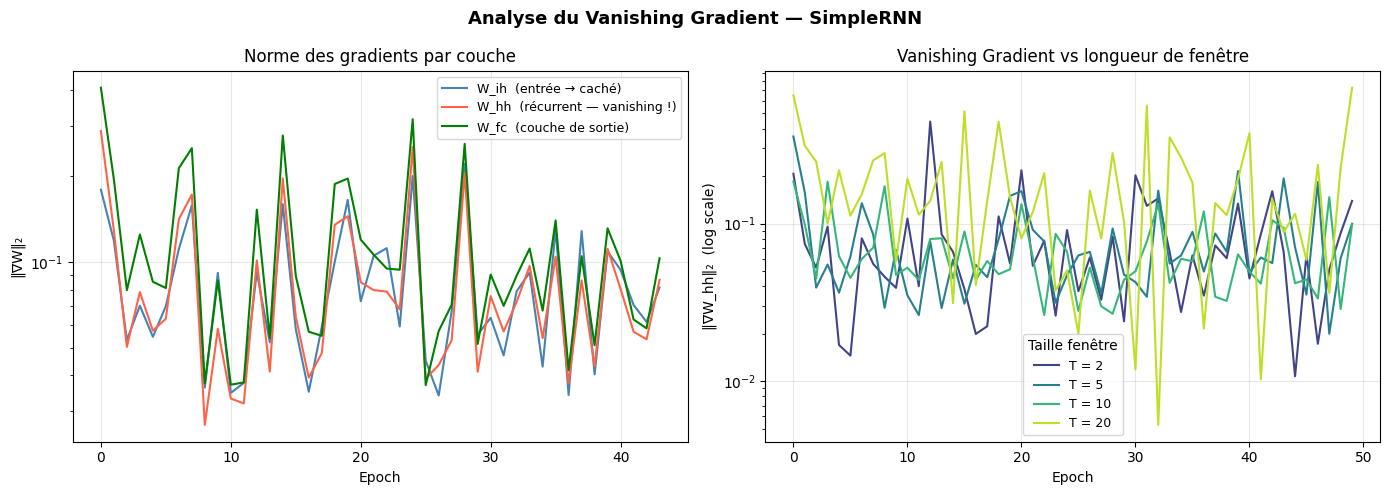

Sauvegardé dans img/rnn_vanishing_gradient.png


In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Analyse du Vanishing Gradient — SimpleRNN', fontsize=13, fontweight='bold')

# ── Normes de gradients par couche ────────────────────────────────────────
ax = axes[0]
colors = {'rnn.weight_ih_l0': 'steelblue', 'rnn.weight_hh_l0': 'tomato', 'fc.weight': 'green'}
labels = {'rnn.weight_ih_l0': 'W_ih  (entrée → caché)',
          'rnn.weight_hh_l0': 'W_hh  (récurrent — vanishing !)',
          'fc.weight'        : 'W_fc  (couche de sortie)'}
for name, grads in grad_history.items():
    if grads:
        ax.plot(grads, label=labels[name], color=colors[name], lw=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('‖∇W‖₂')
ax.set_title('Norme des gradients par couche')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)
ax.set_yscale('log')

# ── Vanishing gradient selon la longueur de fenêtre ───────────────────────
ax = axes[1]

results_vg = {}
for win in WINDOWS_EXP:
    Xs, ys = make_sequences(X_scaled[:-N_TEST], win)
    Xt = torch.tensor(Xs, dtype=torch.float32).to(DEVICE)
    yt = torch.tensor(ys, dtype=torch.float32).to(DEVICE)
    loader_w = DataLoader(TensorDataset(Xt, yt), batch_size=BATCH_SIZE, shuffle=True)

    m = SimpleRNNModel(len(FEATURES), HIDDEN_SIZE, 1).to(DEVICE)
    opt_w = torch.optim.Adam(m.parameters(), lr=LR)
    crit  = nn.MSELoss()
    grad_norms_hh = []

    for ep in range(EPOCHS_EXP):
        m.train()
        for xb, yb in loader_w:
            opt_w.zero_grad()
            loss = crit(m(xb), yb)
            loss.backward()
            opt_w.step()
        if m.rnn.weight_hh_l0.grad is not None:
            grad_norms_hh.append(m.rnn.weight_hh_l0.grad.norm().item())
    results_vg[win] = grad_norms_hh

palette = plt.cm.viridis(np.linspace(0.2, 0.9, len(WINDOWS_EXP)))
for color, win in zip(palette, WINDOWS_EXP):
    if results_vg[win]:
        ax.plot(results_vg[win], label=f'T = {win}', color=color, lw=1.5)

ax.set_xlabel('Epoch')
ax.set_ylabel('‖∇W_hh‖₂  (log scale)')
ax.set_yscale('log')
ax.set_title('Vanishing Gradient vs longueur de fenêtre')
ax.legend(title='Taille fenêtre', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../img/rnn_vanishing_gradient.png', dpi=150, bbox_inches='tight')
plt.show()
print('Sauvegardé dans img/rnn_vanishing_gradient.png')

## 11 — Conclusion et comparaison avec LSTM/GRU

| Modèle | Paramètres | Mémoire | Vanishing gradient |
|--------|-----------|---------|--------------------|
| **SimpleRNN** | ~1.5k | Courte (~3-5 pas) | **Oui** (critique) |
| **GRU** | ~40k | Longue | Non (porte de mise à jour) |
| **LSTM** | ~54k | Longue | Non (cellule de contexte) |

In [77]:
print(f'=== Trace de la fenêtre glissante — {MODEL_NAME} ===')
print(f"{'Étape':<7} {'Jour':<12} {'Réel':>6} {'Prédit':>7} {'Err abs':>8} {'Err %':>7}   Rôle")
print('-' * 75)
for i, d in enumerate(DAY_LABELS):
    err_abs = abs(preds_real[i] - real_real[i])
    err_pct = 100 * err_abs / real_real[i]
    role = '← injecté dans la fenêtre suivante' if i < N_TEST - 1 else '← prédiction finale'
    print(f'  {i}      {d:<12} {real_real[i]:>6.0f} {preds_real[i]:>7.0f} {err_abs:>8.1f} {err_pct:>6.1f}%   {role}')

print(f'\nRésumé : MAE={mae:.1f} | MAPE={mape:.2f}% | RMSE={rmse:.1f} | R²={r2:.4f}')

=== Trace de la fenêtre glissante — RNN ===
Étape   Jour           Réel  Prédit  Err abs   Err %   Rôle
---------------------------------------------------------------------------
  0      Lundi           624     630      5.8    0.9%   ← injecté dans la fenêtre suivante
  1      Mardi           713     715      1.6    0.2%   ← injecté dans la fenêtre suivante
  2      Mercredi        623     712     89.5   14.4%   ← injecté dans la fenêtre suivante
  3      Jeudi           659     651      8.2    1.2%   ← injecté dans la fenêtre suivante
  4      Vendredi        408     477     68.9   16.9%   ← prédiction finale

Résumé : MAE=34.8 | MAPE=6.73% | RMSE=50.7 | R²=0.7624


In [78]:
import json, os

os.makedirs('../results', exist_ok=True)

results_data = {
    'model'      : MODEL_NAME,
    'color'      : 'mediumpurple',
    'val'        : {'MAE': mae_val, 'MAPE': mape_val, 'RMSE': rmse_val, 'R2': r2_val},
    'test'       : {'MAE': mae,     'MAPE': mape,     'RMSE': rmse,     'R2': r2},
    'preds'      : [float(x) for x in preds_real],
    'real'       : [float(x) for x in real_real],
    'day_labels' : DAY_LABELS,
    'test_label' : TEST_LABEL,
}

out_path = f'../results/{MODEL_NAME.lower()}_results.json'
with open(out_path, 'w') as f:
    json.dump(results_data, f, indent=2)
print(f'Résultats sauvegardés → {out_path}')

Résultats sauvegardés → ../results/rnn_results.json
